# The Boolean pandemic

__Master Program DSAA    
Machine Learning 2020 - Group Project__

Group:


__Project Description__  

On January 1st, 2020, an epidemy was originated in Albuquerque, in New Mexico state, and spread on the following days to Santa Fe and Taos. It is estimated that the epidemy has already affected more than 1000 people at the end of February, with a mortality rate of more than 50%.  
While the conditions of the transmission of the virus is still unknown and there are no certainties of what leads a patient to survive or not to the virus, it seems there are some groups of people more prone to survive than others.
In this challenge, your goal is to build a predictive model that answers the question “What are the people more likely to survive to the boolean pandemic?” using the small quantity of data accessible of the patients – name, birthday date, severity of the disease, money of expenses associated to the treatment of each family, city and others.
As data scientists, your team is asked to analyze and transform as needed the data available and apply different models in order to answer in the more accurate way the defined question. Are you able to design a model that can predict if a patient will survive, or not, to the boolean pandemic?

__`Data fields`__

- **Patient_ID** - The unique identifier of the patient  
- **Family_Case_ID** - The family identification  
- **Severity** - The severity of the disease, where 1 is the lowest and 3 the highest severity  
- **Name** - The name of the patient  
- **Birthday_year** - The year of birthday of the patient  
- **Parents_Siblings_Infected** - The number of parents and/or siblings infected  
- **Partner_Children_Infected** - The number of partner and/or children infected  
- **Medical_Expenses_Family** - The medical expenses associated to try to contain the epidemy on the family  
- **Medical_Tent** - The medical tent where the patient is / was lodged  
- **City** - The original city of the patient  
  

__`Target`__
- **Deceased** - Flag if the patient deceased or not with the virus (0 = No, 1 = Yes)  

## 1. Import libraries

In [8]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)
import re
from collections import Counter

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, KFold
from sklearn.feature_selection import RFECV, SelectKBest, chi2, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer, MissingIndicator
#from sklearn.impute import KNNImputer,
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from tqdm import tqdm

#from imblearn.over_sampling import SMOTE, RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.pipeline import Pipeline

from xgboost import XGBClassifier

#from pandas_profiling import ProfileReport
import category_encoders as ce

## 2. Import data

In [9]:
#read train data from csv file
df_train = pd.read_csv(r'train.csv')

In [10]:
#let's have a look at first 5 records
df_train.head().transpose()

,0,1,2,3,4
Patient_ID,1,2,3,4,5
Family_Case_ID,4696,21436,7273,8226,19689
Severity,3,1,3,3,3
Name,Miss Linda Betty,Ms. Ramona Elvira,Mr. Mario Vernon,Mr. Hector Joe,Ms. Jennie Debra
Birthday_year,NaN,1966,1982,1997,1994
Parents or siblings infected,0,0,0,0,0
Wife/Husband or children infected,0,1,0,0,0
Medical_Expenses_Family,225,1663,221,220,222
Medical_Tent,NaN,NaN,NaN,NaN,NaN
City,Santa Fe,Albuquerque,Santa Fe,Santa Fe,Santa Fe


In [11]:
#read test data from csv file
df_test = pd.read_csv(r'test.csv')

In [12]:
#let's have a look at first 5 records
df_test.head().transpose()

,0,1,2,3,4
Patient_ID,901,902,903,904,905
Family_Case_ID,49242,10400,10795,62440,81311
Severity,3,3,3,3,2
Name,Mr. Jody Pedro,Mr. Kevin Brent,Mr. Frankie Cary,Mr. Rick Pete,Mr. Matthew Erick
Birthday_year,NaN,1988,1981,NaN,1996
Parents or siblings infected,0,0,1,0,0
Wife/Husband or children infected,0,0,0,1,0
Medical_Expenses_Family,203,631,376,405,378
Medical_Tent,NaN,NaN,NaN,NaN,NaN
City,Santa Fe,Santa Fe,Albuquerque,Albuquerque,Santa Fe


## 3. Data pre-processing

### 3.1. Data Analysis

In [13]:
# Summary statistics for all variables 
def summary(dataframe):
    summary=dataframe.describe(include='all') 
    summary=summary.transpose()
    return summary.head(len(summary))

In [14]:
summary(df_train)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Patient_ID,900,NaN,NaN,NaN,450.5,259.952,1,225.75,450.5,675.25,900
Family_Case_ID,900,NaN,NaN,NaN,14305.8,25418.2,345,8203,13593.5,18906.5,742836
Severity,900,NaN,NaN,NaN,2.31333,0.834223,1,2,3,3,3
Name,900,899,Mr. Samuel Darnell,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Birthday_year,723,NaN,NaN,NaN,1990.27,14.5233,1940,1982,1992,1999.5,2019
Parents or siblings infected,900,NaN,NaN,NaN,0.38,0.803247,0,0,0,0,6
Wife/Husband or children infected,900,NaN,NaN,NaN,0.521111,1.09839,0,0,0,1,8
Medical_Expenses_Family,900,NaN,NaN,NaN,895.743,1385.83,0,221,405,861.25,14345
Medical_Tent,198,8,C,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,898,3,Santa Fe,649,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
Patient_ID                           400 non-null int64
Family_Case_ID                       400 non-null int64
Severity                             400 non-null int64
Name                                 400 non-null object
Birthday_year                        318 non-null float64
Parents or siblings infected         400 non-null int64
Wife/Husband or children infected    400 non-null int64
Medical_Expenses_Family              400 non-null int64
Medical_Tent                         89 non-null object
City                                 400 non-null object
dtypes: float64(1), int64(6), object(3)
memory usage: 31.3+ KB


In [16]:
#variables with null vallues
df_train.isna().sum()

Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64

In [74]:
#variables with null vallues
df_test.isna().sum()

Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                         82
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         311
City                                   0
dtype: int64

#### Comments:
- We have 900 records in train dataset and 400 records on test dataset.  
- Both datasets have the same information, with the exception of target value that is missing on test dataset.  
- There some null values:
    - Train: Birthday_year, Medical_tent and City
    - Test: Birthday_year and Medical_tent

In [11]:
# pandas profiling is a cool feature for exploratory data analysis. More information here: https://github.com/pandas-profiling/pandas-profiling

profile = ProfileReport(df_train, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_widgets()

#### Comments:

- Birthday_year and Medical_Tent have the highest number of missing values (19.7% and 76.1% respectively)  
- We have 900 records and 0 duplicate rows  
- Variables Patient_ID, Family_Case_ID and Name are likely to be dropped or used for feature engineering  
- There are two records without City information, since Santa Fe is largely the most frequent city it seems reasonable to assume those two records as from Santa Fe.

__`Target variable - 'Deceased'`__

Let's have a look at the distribution of variables among deceased and survivors.

In [18]:
df_train.groupby(by="Deceased").mean().transpose()

Deceased,0,1
Patient_ID,449.423631,451.175407
Family_Case_ID,13619.536023,14736.466546
Severity,1.962536,2.533454
Birthday_year,1991.698305,1989.280374
Parents or siblings infected,0.463977,0.327306
Wife/Husband or children infected,0.475504,0.549729
Medical_Expenses_Family,1340.755043,616.504521


In [21]:
deceased_temp = df_train[df_train.Deceased == 1]
survived_temp = df_train[df_train.Deceased == 0]

ValueError: cannot convert float NaN to integer

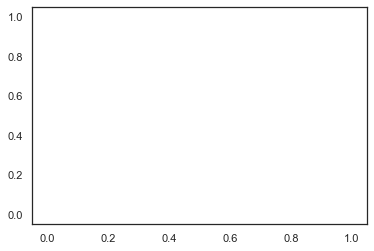

In [23]:
sns.distplot(deceased_temp['Birthday_year'], kde = False, label='Deceased')
sns.distplot(survived_temp['Birthday_year'], kde = False, label='Survived')

plt.legend(prop={'size': 12})
plt.xlabel('year of birth')
plt.ylabel('Frequency')

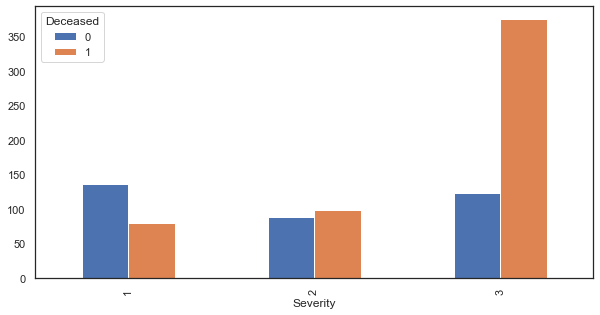

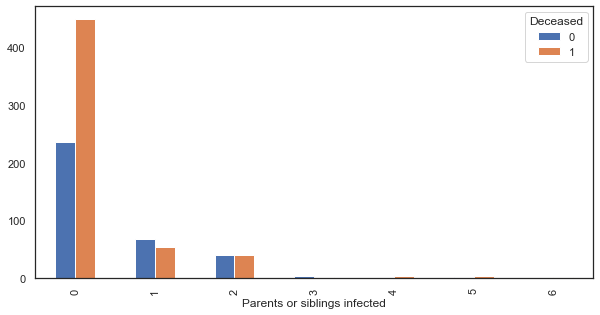

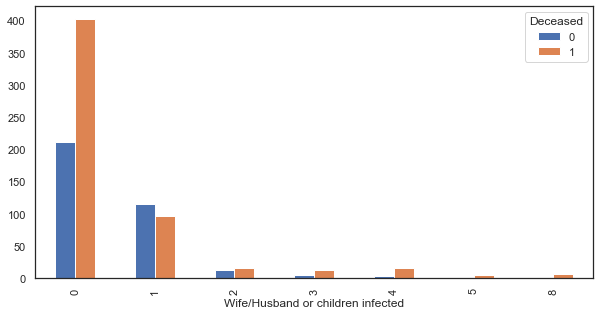

In [24]:
#let's have a look at some variables distribution per deceased
columns = ['Severity', 'Parents or siblings infected', 'Wife/Husband or children infected']

for col in columns:
    pd.crosstab(df_train[col],df_train.Deceased).plot(kind='bar',
                                          figsize=(10,5))

__`Medical Tent`__

In [25]:
def perc_table(index, columns, values):
    perc_table = pd.crosstab(index = index, 
                     columns = columns, 
                     values = values, 
                     aggfunc='count', margins = True,
                     normalize='columns').applymap('{:.3%}'.format)
    return perc_table

In [27]:
perc_table(df_train.Medical_Tent, df_train.City, df_train.index)

City,Albuquerque,Santa Fe,Taos,All
Medical_Tent,,,,
A,10.145%,6.504%,0.000%,7.653%
B,31.884%,17.886%,0.000%,22.449%
C,30.435%,27.642%,50.000%,29.082%
D,18.841%,14.634%,0.000%,15.816%
E,7.246%,20.325%,25.000%,15.816%
F,1.449%,8.943%,25.000%,6.633%
G,0.000%,3.252%,0.000%,2.041%
T,0.000%,0.813%,0.000%,0.510%


#### Comments:
From the table above we can observe that there are no rules we can establish for the Medical tents locations that could help us populate the missing values.  
Since we don't have enough information we have two possibilities:
- drop the column,
- fill missing values with No_tent.

__`Name`__

In [28]:
print(df_train.Name.str.split(' ').str[0].unique())

['Miss' 'Ms.' 'Mr.' 'Master']


#### Comments:
All records have name filled in and all start by either 'Miss', 'Ms.', 'Mr.' or 'Master. This information is quite useful to generate a new field Gender!

### 3.2. Data Manipulation

In [136]:
X = df_train.drop('Deceased', axis = 1)
y = df_train['Deceased']

In [137]:
df_test_copy = df_test.copy(deep=True)

### 3.2.1. Missing values

In [138]:
# fill in medical tent 
X['Medical_Tent'].fillna('No_tent', inplace = True)

In [139]:
df_test_copy['Medical_Tent'].fillna('No_tent', inplace = True)

In [140]:
#Fill in birthday year

imputer = SimpleImputer(strategy='mean').fit(X.loc[:,['Birthday_year']])

X.loc[:,'Birthday_year'] = imputer.transform(X.loc[:,['Birthday_year']]).astype(int)

In [141]:
df_test_copy.loc[:,'Birthday_year'] = imputer.transform(df_test_copy.loc[:,['Birthday_year']]).astype(int)

In [142]:
#Fill in city

X['City'].fillna('Santa Fe', inplace = True)

### 3.2.2. Feature Engineering

__`Gender`__

In [143]:
gender_dict ={'Miss' : 'F', 'Ms.' : 'F', 'Mrs.':'F', 
                    'Mr.' : 'M', 'Master' : 'M'} 

X['Gender'] = X.Name.str.split(' ').str[0].map(gender_dict) 

In [144]:
df_test_copy['Gender'] = df_test_copy.Name.str.split(' ').str[0].map(gender_dict) 

__`Family Death ratio`__

In [145]:
#temp_group = df_train.groupby('Family_Case_ID')
#X['number_family_cases'] = temp_group['Patient_ID'].transform('count')
#X['number_family_deaths'] = temp_group['Deceased'].transform(sum)
#X['family_death_ratio'] = X['number_family_deaths']/ X['number_family_cases']

#X.drop(['number_family_cases', 'number_family_deaths'], axis = 1, inplace=True)

In [148]:
#df_test_copy = df_test_copy.merge(X[['family_death_ratio', 'Family_Case_ID']], how = 'left',
#left_on = 'Family_Case_ID', right_on = 'Family_Case_ID')

In [149]:
#df_test_copy['family_death_ratio'].fillna(0, inplace = True)

In [150]:
#df_test_copy.drop_duplicates(inplace=True)

__`Expenses per person (pp)`__

In [151]:
X['Expenses_pp'] = X['Medical_Expenses_Family'] / (X['Parents or siblings infected'] + X['Wife/Husband or children infected'] + 1)


In [152]:
df_test_copy['Expenses_pp'] = df_test_copy['Medical_Expenses_Family'] / (df_test_copy['Parents or siblings infected'] + df_test_copy['Wife/Husband or children infected'] + 1)

In [153]:
X.drop('Medical_Expenses_Family', axis = 1, inplace=True)

In [154]:
df_test_copy.drop('Medical_Expenses_Family', axis = 1, inplace=True)

__`Family Avg Severity`__

In [155]:
total_db = X.append(df_test)
total_db = total_db[['Family_Case_ID','Severity']] .groupby(by='Family_Case_ID').mean()

In [156]:
X['family_severity'] = X.merge(total_db, how='left', left_on ='Family_Case_ID', right_on = 'Family_Case_ID')['Severity_y']

In [157]:
X['family_severity'] = X['family_severity'].fillna(0)

In [158]:
df_test_copy['family_severity'] = df_test_copy.merge(total_db, how='left', left_on ='Family_Case_ID', right_on = 'Family_Case_ID')['Severity_y']

In [159]:
df_test_copy['family_severity']= df_test_copy['family_severity'].fillna(0)

__`Encoding`__

In [162]:
# Encode categorical variables to dummy variables
cat_features=['Medical_Tent', 'City', 'Gender']

ce_one_hot = ce.OneHotEncoder(cols = cat_features, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [163]:
df_test_copy = ce_one_hot.fit_transform(df_test_copy)

__`Drop Columns`__

In [164]:
cols_drop = ['Patient_ID','Family_Case_ID','Name', 
             'Medical_Tent_G', 'City_Taos','Gender_M']

In [165]:
X.drop(columns = cols_drop, inplace = True)
df_test_copy.drop(columns = cols_drop, inplace = True)

### 3.3. Train test split

In [166]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2, 
                                                  stratify = y,
                                                  random_state = 15)

### 3.4 Feature Selection

#### 3.4.1 Extra Trees Classifier
- trees classifiers works as n ( in this case 50) decision trees, the good think about this is the possibility to plot and make sense of what is going on
- And the feature_selection algorithm select the features that are relevant

In [167]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()


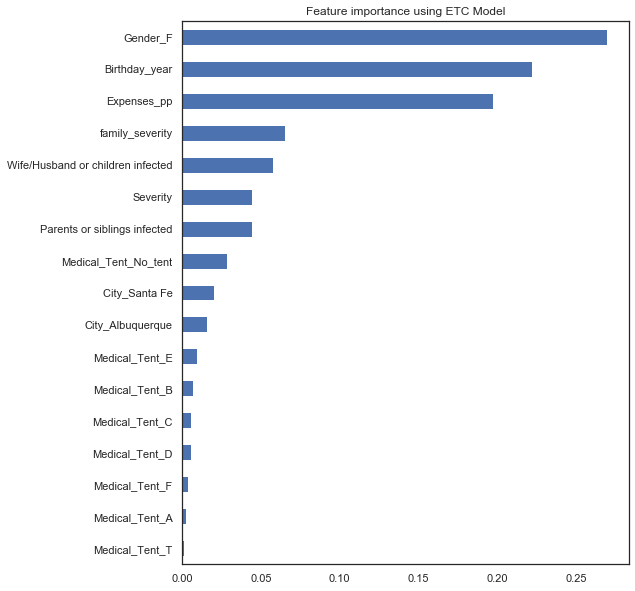

Medical_Tent_T                       0.000911
Medical_Tent_A                       0.002539
Medical_Tent_F                       0.003665
Medical_Tent_D                       0.005648
Medical_Tent_C                       0.005851
Medical_Tent_B                       0.006851
Medical_Tent_E                       0.009344
City_Albuquerque                     0.016060
City_Santa Fe                        0.020217
Medical_Tent_No_tent                 0.028722
Parents or siblings infected         0.044159
Severity                             0.044161
Wife/Husband or children infected    0.057675
family_severity                      0.065066
Expenses_pp                          0.197360
Birthday_year                        0.221864
Gender_F                             0.269908
dtype: float64

In [168]:
ETC = ExtraTreesClassifier(n_estimators=50)
ETC = ETC.fit(X_train, y_train)
coef_ETC = pd.Series(ETC.feature_importances_, index = X_train.columns)
plot_importance(coef_ETC,'ETC')
coef_ETC.abs().sort_values()  

In [169]:
model = SelectFromModel(ETC, prefit=True)
model.transform(X_train)
ETC_indices = model.get_support(indices= True)
ETC_feature = X_train.iloc[:,ETC_indices].columns
ETC_feature

Index(['Birthday_year', 'Gender_F', 'Expenses_pp', 'family_severity'], dtype='object')

#### 3.4.2. Correlation

In [170]:
def cor_heatmap(cor):
    mask = np.triu(np.ones_like(cor, dtype=bool))
    plt.figure(figsize=(14,12))
    sns.set(font_scale=1.4, style = 'white')
    sns.heatmap(data = cor, annot = True, annot_kws={"size": 10},
                mask = mask, cmap = plt.cm.Reds, fmt='.1f')
    plt.show()

In [171]:
temp_X = X_train.copy(deep=True)
temp_X['target'] = y_train

In [172]:
corr_spearman = temp_X.corr('spearman')

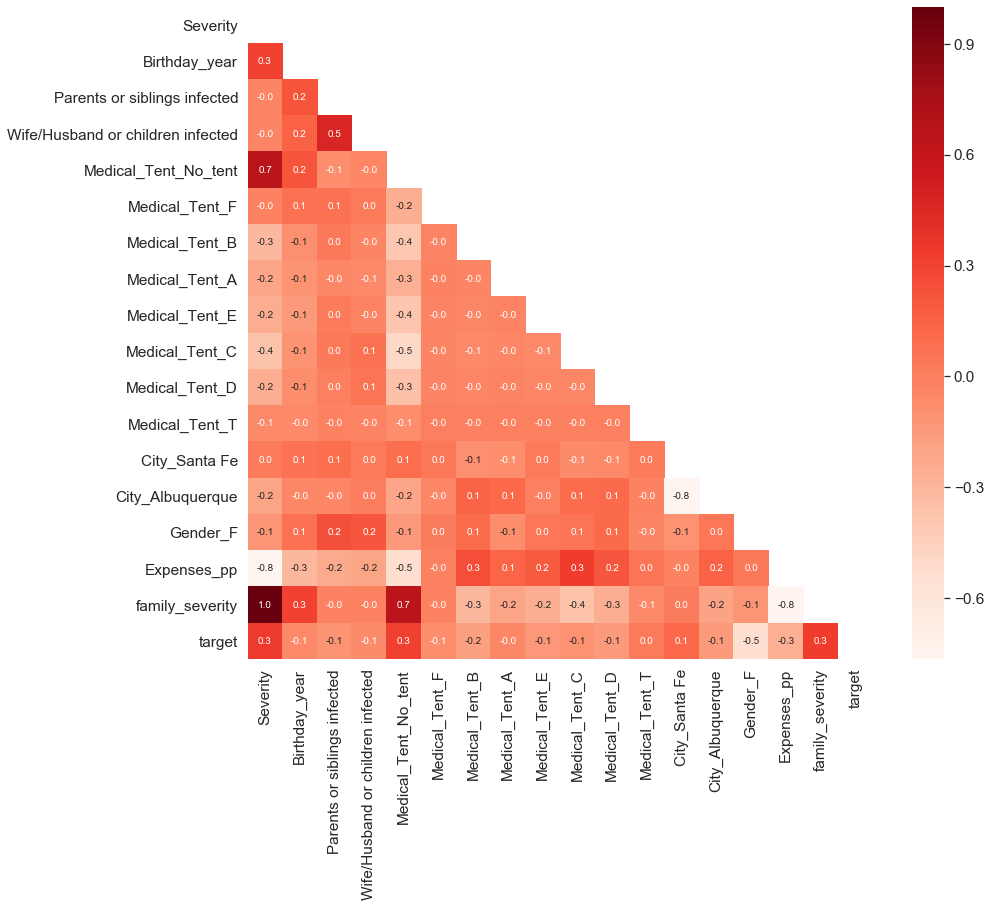

In [173]:
cor_heatmap(corr_spearman)

#### 3.4.3. Lasso

In [174]:
lasso = LassoCV()
lasso.fit(X = X_train, y = y_train)
print("Best alpha using built-in LassoCV: %f" % lasso.alpha_)

Best alpha using built-in LassoCV: 0.102916


In [175]:
coef_lasso = pd.Series(lasso.coef_,index=X.columns)
coef_lasso

Severity                             0.000000
Birthday_year                       -0.003424
Parents or siblings infected        -0.000000
Wife/Husband or children infected    0.000000
Medical_Tent_No_tent                 0.000000
Medical_Tent_F                      -0.000000
Medical_Tent_B                      -0.000000
Medical_Tent_A                      -0.000000
Medical_Tent_E                      -0.000000
Medical_Tent_C                      -0.000000
Medical_Tent_D                      -0.000000
Medical_Tent_T                       0.000000
City_Santa Fe                        0.000000
City_Albuquerque                    -0.000000
Gender_F                            -0.061115
Expenses_pp                         -0.000121
family_severity                      0.000000
dtype: float64

In [176]:
print("Lasso picked " + str(sum(coef_lasso != 0)) + " variables and eliminated the other " +  str(sum(coef_lasso == 0)) + " variables")

Lasso picked 3 variables and eliminated the other 14 variables


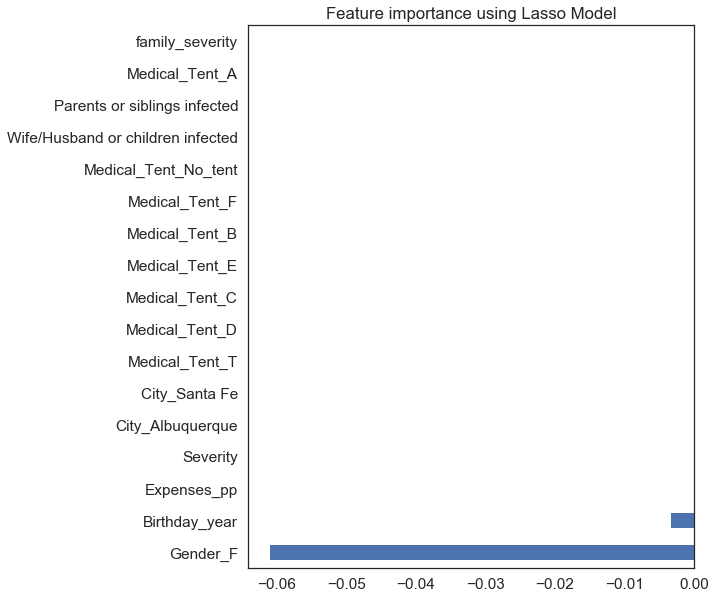

In [180]:
plot_importance(coef_lasso,'Lasso')

In [198]:
# Extracting important features according to Lasso Regression

lasso_features = coef_lasso.sort_values().abs() > 0
lasso_features = lasso_features[lasso_features].index.values
lasso_features

array(['Gender_F', 'Birthday_year', 'Expenses_pp'], dtype=object)

#### 3.4.4. RFE_CV

In [193]:
rf_clf = RandomForestClassifier(random_state = 15)
rf_clf.fit(X_train, y_train)

rfecv = RFECV(rf_clf, cv= 5, step=1)
rfecv = rfecv.fit(X_train, y_train)

rfecv_mask = rfecv.get_support() 

rfecv_features = [] 

for bool, feature in zip(rfecv_mask, X_train.columns):
    if bool:
        rfecv_features.append(feature)
        
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', rfecv_features)

Optimal number of features : 5
Best features : ['Birthday_year', 'Wife/Husband or children infected', 'Gender_F', 'Expenses_pp', 'family_severity']


In [194]:
coef_rfecv = pd.Series(rf_clf.feature_importances_,index=X.columns).abs().sort_values()
coef_rfecv


Medical_Tent_T                       0.000187
Medical_Tent_F                       0.002398
Medical_Tent_A                       0.003484
Medical_Tent_B                       0.004132
Medical_Tent_E                       0.004782
Medical_Tent_D                       0.005331
Medical_Tent_C                       0.006315
City_Albuquerque                     0.013153
City_Santa Fe                        0.021934
Medical_Tent_No_tent                 0.037387
Severity                             0.039123
Parents or siblings infected         0.041822
family_severity                      0.042672
Wife/Husband or children infected    0.046704
Gender_F                             0.223084
Birthday_year                        0.251610
Expenses_pp                          0.255880
dtype: float64

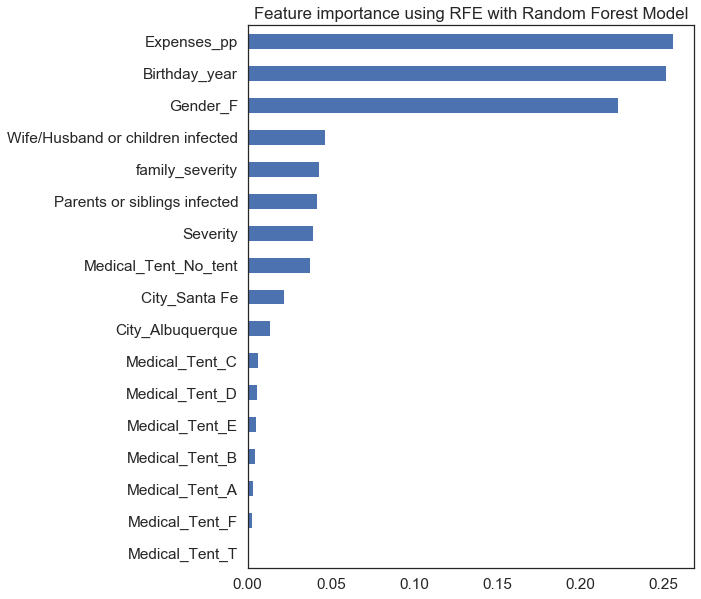

In [195]:
plot_importance(coef_rfecv,'RFE with Random Forest')

#### 3.4.5 Selected Features

In [ ]:
ETC_feature, rfecv_features

In [199]:
#Get the repeated features for the 3 criteria
feat_freq = pd.Series(np.concatenate([ ETC_feature, rfecv_features, lasso_features])).value_counts()
feat_freq          

Expenses_pp                          3
Gender_F                             3
Birthday_year                        3
family_severity                      2
Wife/Husband or children infected    1
dtype: int64

In [232]:
# Get features that fulfil more than 2 criteria
features = feat_freq[feat_freq >= 1].index.tolist()
features

['Expenses_pp',
 'Gender_F',
 'Birthday_year',
 'family_severity',
 'Wife/Husband or children infected']

In [210]:
X_train_F = X_train[features]
df_test_copy_F = df_test_copy[features]
X_val_F = X_val[features]

## 4. Model Implementation

### Model A - XGBoost

In [535]:
mod_A_pipe = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        (
            'classifier', BaggingClassifier(
                base_estimator= XGBClassifier(
                    colsample_bytree = 1.0, 
                    eta = 0.63, 
                    max_depth = 2),
                n_estimators=10,
                max_features=1.0,
                bootstrap=True,
                random_state = 15)
        )
    ]
)

In [536]:
mod_A_param_grid = {
    'scaler': [
        MinMaxScaler(), 
        MinMaxScaler(feature_range=(-1,1)),
        RobustScaler(),
        StandardScaler(),
        PowerTransformer()
    ],
    'classifier__n_estimators': list(np.arange(5,50,1)),
    'classifier__max_features': list(np.arange(2,9,1)),
    'classifier__bootstrap': [True, False],
    
}

In [537]:
#to be able to excatly reproduce the values we want to fix the seed, thus we initiate the Kfold for the GridSearch separetly and as follow:
kfold = KFold(n_splits = 5, random_state = 15)

In [538]:
mod_A_clf = GridSearchCV(
    mod_A_pipe, 
    mod_A_param_grid, 
    cv = kfold, 
    verbose = 2,
    n_jobs = -1,
    return_train_score=True,
    scoring='accuracy'
)

In [539]:
mod_A = mod_A_clf.fit(X, y)

Fitting 5 folds for each of 3150 candidates, totalling 15750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   15.8s


KeyboardInterrupt: 

In [ ]:
mod_A.best_params_

In [ ]:
print('Mean: ', mod_A.cv_results_['mean_test_score'][mod_A.best_index_])
print('Split 1: ', mod_A.cv_results_['split0_test_score'][mod_A.best_index_])
print('Split 2: ', mod_A.cv_results_['split1_test_score'][mod_A.best_index_])
print('Split 3: ', mod_A.cv_results_['split2_test_score'][mod_A.best_index_])
print('Split 4: ', mod_A.cv_results_['split3_test_score'][mod_A.best_index_])
print('Split 5: ', mod_A.cv_results_['split4_test_score'][mod_A.best_index_])

**Prediction**

In [ ]:
mod_A_labels_predict = mod_A.predict(df_test_copy)

In [ ]:
labels_df_A = pd.DataFrame(data = mod_A_labels_predict)

In [ ]:
df_test['Deceased'] = labels_df_A

In [ ]:
#export to csv according to sample
df_test.to_csv('m20190876_v1.csv',columns=['Patient_ID','Deceased'],index=False)

### Model B.1 - Decision Tree

In [204]:
mod_B_clf = DecisionTreeClassifier(random_state=15)
path = mod_B_clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    mod_B_clf = DecisionTreeClassifier(random_state=15, ccp_alpha=ccp_alpha)
    mod_B_clf.fit(X_train, y_train)
    clfs.append(clf)

AttributeError: 'DecisionTreeClassifier' object has no attribute 'cost_complexity_pruning_path'

In [102]:
scaler=MinMaxScaler()
columns=X.columns
X=pd.DataFrame(scaler.fit_transform(X))
X.columns=columns
df_test_copy=pd.DataFrame(scaler.transform(df_test_copy))
df_test_copy.columns=columns

### Model B.2 - Ada Boost

In [214]:
parameter_space = {
    'n_estimators':[100,150,200,250],
    'learning_rate':[1.0,0.9,0.8],
    'algorithm':['SAMME.R']
}
model=AdaBoostClassifier()
clf_adaboost = GridSearchCV(model, parameter_space,n_jobs=-1,verbose=5,cv=5)
clf_adaboost.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='warn', n_jobs=-1,
             param_grid={'algorithm': ['SAMME.R'],
                         'learning_rate': [1.0, 0.9, 0.8],
                         'n_estimators': [100, 150, 200, 250]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [215]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf_adaboost.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf_adaboost.cv_results_['mean_test_score']
stds = clf_adaboost.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_adaboost.cv_results_['params']):
    if mean>.98:
        print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'algorithm': 'SAMME.R', 'learning_rate': 0.8, 'n_estimators': 150}
------------------------------------------------------------------------------------------------------------------------


In [216]:
clf_adaboost.score(X_val,y_val)

0.7944444444444444

### Model B.3 - Gradient Boost

In [223]:
parameter_space = {
    'loss':[ 'exponential'],
    'n_estimators':[60],
    'max_depth':[7,9,11,13],
    'min_samples_leaf':[10,20,50,100],
    'max_features':[None]
    
    
    
}
model=GradientBoostingClassifier()
clf_gradboost = GridSearchCV(model, parameter_space,n_jobs=-1,verbose=5,cv=5)
clf_gradboost.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no...
                                                  presort='auto',
  

In [224]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf_gradboost.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf_gradboost.cv_results_['mean_test_score']
stds = clf_gradboost.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_gradboost.cv_results_['params']):
    if mean>.98:
        print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'loss': 'exponential', 'max_depth': 13, 'max_features': None, 'min_samples_leaf': 20, 'n_estimators': 60}
------------------------------------------------------------------------------------------------------------------------


In [225]:
clf_gradboost.score(X_val,y_val)

0.8

### Model B.4 - Random Forest

In [229]:
parameter_space = {
    'n_estimators':[60,80,100,120],
    'criterion':['entropy'],
    'max_depth':[7,8,9,10,11,12,13],
    'oob_score':[True],
    'bootstrap':[True],
    'min_samples_leaf':[1,2,3,4,5,10,20],
    'max_features':[None]
    
}
model=RandomForestClassifier()
clf_randforest = GridSearchCV(model, parameter_space,n_jobs=-1,verbose=5,cv=5)
clf_randforest.fit(X_train,y_train)

Fitting 5 folds for each of 196 candidates, totalling 980 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed:   51.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [230]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf_randforest.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf_randforest.cv_results_['mean_test_score']
stds = clf_randforest.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_randforest.cv_results_['params']):
    if mean>.984:
        print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 120, 'oob_score': True}
------------------------------------------------------------------------------------------------------------------------


In [231]:
clf_randforest.score(X_val,y_val)

0.7833333333333333

### Model C - Neural Network

In [113]:
parameter_space = {
    'hidden_layer_sizes':[(16,16),(8,8),(12,12),(16,8)],
    'activation':[ 'relu'],
    'solver':['lbfgs'],
    'max_iter':[50,75,100,125,150,175,200],
    'learning_rate':['constant'],
    

}
model=MLPClassifier()
clf_NN = GridSearchCV(model, parameter_space,n_jobs=-1,verbose=5,cv=5)
clf_NN.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 138 out of 140 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'activation': ['re

In [114]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf_NN.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf_NN.cv_results_['mean_test_score']
stds = clf_NN.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_NN.cv_results_['params']):
    if mean>.1:
        print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'activation': 'relu', 'hidden_layer_sizes': (8, 8), 'learning_rate': 'constant', 'max_iter': 75, 'solver': 'lbfgs'}
------------------------------------------------------------------------------------------------------------------------
0.810 (+/-0.046) for {'activation': 'relu', 'hidden_layer_sizes': (16, 16), 'learning_rate': 'constant', 'max_iter': 50, 'solver': 'lbfgs'}
0.803 (+/-0.041) for {'activation': 'relu', 'hidden_layer_sizes': (16, 16), 'learning_rate': 'constant', 'max_iter': 75, 'solver': 'lbfgs'}
0.807 (+/-0.037) for {'activation': 'relu', 'hidden_layer_sizes': (16, 16), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'lbfgs'}
0.808 (+/-0.047) for {'activation': 'relu', 'hidden_layer_sizes': (16, 16), 'learning_rate': 'constant', 'max_iter': 125, 'solver': 'lbfgs'}
0.794 (+/-0.035) for {'activation': 'relu', 'hidden_lay

In [115]:
clf_NN.score(X_val,y_val)

0.7888888888888889

### Model D - KNN

In [116]:
parameter_space = {
    'n_neighbors':[21,23,25,27,29,31],
    'weights':['uniform'],
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size':[10,20,30,40,50,60,70,80,90,100],
    'p':[1]
    

}
model=KNeighborsClassifier()
clf_KNN = GridSearchCV(model, parameter_space,n_jobs=-1,verbose=5,cv=5)
clf_KNN.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1168 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    3.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'n_neighbors': [21, 23, 25, 27, 29, 31], 'p': [1],
                         'weights': ['uniform']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [117]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf_KNN.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf_KNN.cv_results_['mean_test_score']
stds = clf_KNN.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_KNN.cv_results_['params']):
    if mean>.818:
        print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 23, 'p': 1, 'weights': 'uniform'}
------------------------------------------------------------------------------------------------------------------------


In [118]:
clf_KNN.score(X_val,y_val)

0.8055555555555556

### Model E - SVM

### Model F - Logistic Regression

In [119]:
parameter_space = {
    'penalty':['l1', 'l2'],
    #'dual': [False],
    #'tol':[1e-4,],
   # 'C':[1.0],
    'fit_intercept':[True,False],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'multi_class':['ovr', 'multinomial']
}
model=LogisticRegression()
clf_logreg = GridSearchCV(model, parameter_space,n_jobs=-1,verbose=5,cv=5)
clf_logreg.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'multi_class': ['ovr', 'multinomial'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_tr

In [120]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf_logreg.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf_logreg.cv_results_['mean_test_score']
stds = clf_logreg.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_logreg.cv_results_['params']):
    if mean>.818:
        print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'fit_intercept': True, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}
------------------------------------------------------------------------------------------------------------------------


In [121]:
clf_logreg.score(X_val,y_val)

0.8222222222222222

## 5. Bagging / Stacking / Voting Classifier

### Bagging

In [ ]:
modelKNN = KNeighborsClassifier()
bagging_KNN = BaggingClassifier(base_estimator = modelKNN, random_state = 5)


In [ ]:
NN=MLPClassifier(hidden_layer_sizes=(16,16))
bagging_NN = BaggingClassifier(base_estimator = NN, random_state = 5)

### Stacking

In [ ]:
estimators = [#('rf', RandomForestClassifier(random_state=5)),
    ('ab',AdaBoostClassifier(algorithm= 'SAMME.R', learning_rate= 1.0, n_estimators= 100,random_state = 5)),
    ('xgb',XGBClassifier(
                    colsample_bytree = 1.0, 
                    eta = 0.63, 
                    max_depth = 2
                )),
    ('knn',KNeighborsClassifier()),
    ('nn',MLPClassifier(hidden_layer_sizes=(16,16))),
              ]

In [ ]:
SC = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

### Voting Classifier

In [122]:
VC = VotingClassifier(estimators=[('lr', clf_logreg), ('rf', clf_randforest), ('gb',clf_gradboost), 
                                  ('ab',clf_adaboost), ('mlp',clf_NN), ('knn',clf_KNN)], voting='soft')

In [123]:
VC.fit(X_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 196 candidates, totalling 980 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 738 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed:   24.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  66 out of  80 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.8s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  60 | elapsed:    1.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  55 out of  60 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 138 out of 140 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1168 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    3.2s finished


VotingClassifier(estimators=[('lr',
                              GridSearchCV(cv=5, error_score=nan,
                                           estimator=LogisticRegression(C=1.0,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='auto',
                                                                        n_jobs=None,
                                                                        penalty='l2',
                       

In [124]:
VC.score(X_val,y_val)

0.8333333333333334

In [90]:
VC.fit(X,y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 196 candidates, totalling 980 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 949 out of 980 | elapsed:   22.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed:   23.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  66 out of  80 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 out of  60 | elapsed:    1.9s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  55 out of  60 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 138 out of 140 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1168 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.0s finished


VotingClassifier(estimators=[('lr',
                              GridSearchCV(cv=5, error_score=nan,
                                           estimator=LogisticRegression(C=1.0,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='auto',
                                                                        n_jobs=None,
                                                                        penalty='l2',
                       

In [95]:
df_test_copy

,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Tent_No_tent,Medical_Tent_F,Medical_Tent_B,Medical_Tent_A,Medical_Tent_E,Medical_Tent_C,Medical_Tent_D,Medical_Tent_T,City_Santa Fe,City_Albuquerque,Gender_F,family_death_ratio,Expenses_pp
0,1.0,0.632911,0.000000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.014151
1,1.0,0.607595,0.000000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.043987
2,1.0,0.518987,0.166667,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.013106
3,1.0,0.632911,0.000000,0.125,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.014116
4,0.5,0.708861,0.000000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.026351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1.0,0.632911,0.000000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.015406
396,1.0,0.632911,0.000000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.014082
397,0.0,0.683544,0.000000,0.125,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.133496
398,1.0,0.848101,0.333333,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.5,0.013175


In [91]:
vc=VC.predict(df_test_copy)

In [92]:
vers = pd.DataFrame( vc,df_test.Patient_ID.values )
vers.rename(columns={0: "Deceased"},inplace=True)
vers.rename_axis("Patient_ID",inplace=True)


In [93]:
vers

,Deceased
Patient_ID,
901,0
902,1
903,0
904,0
905,0
...,...
1296,0
1297,0
1298,0


In [94]:
vers.to_csv(f'versions/Group6_version__alex.csv', index=True)

## 6. Performance Comparison and Final Thoughts